In [3]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/')
print(sys.path)

['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages']
['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/']


In [4]:
######################################################
######################################################
##########       GLOBAL ANALYSIS           ###########
######################################################
######################################################

In [4]:
import numpy as np
import pandas as pd
import scvelo as sv
import anndata
import scanpy as sc
import time
import skdim
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy import stats
import elpigraph_ps_tools
import importlib
importlib.reload(elpigraph_ps_tools)
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter

import seaborn as sns

def get_surrogate_signature(adata,score,n_top_genes=200,negative_side=False,producePlot=False):
    X = adata.X.T
    gene_corrs = np.zeros(len(X))
    for i in range(len(X)):
        gene_corrs[i] = stats.spearmanr(X[i,:],score)[0]
    #mn_corr = np.mean(np.abs(gene_corrs))
    if not negative_side:
        inds = np.flip(np.argsort(gene_corrs))
    else:
        inds = np.argsort(gene_corrs)
    #print(gene_corrs[inds])
    inds_top = inds[0:n_top_genes]
    signature_gene_names = adata.var_names[inds_top]
    signature_scores = np.mean(X[inds_top,:],axis=0)
    #print(*signature_gene_names)
    if producePlot:
        plt.scatter(score,signature_scores,c='k')
        plt.xlabel('Initial score')
        plt.ylabel('Surrogate score')
        plt.title('Corr = '+str(stats.spearmanr(signature_scores,score)[0]))
        plt.show()
    return signature_gene_names,signature_scores,gene_corrs,inds_top

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled

def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def weighted_mean(x, w):
    """Weighted Mean"""
    return np.average(x,weights=w)
def weighterd_covariance(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - weighted_mean(x, w)) * (y - weighted_mean(y, w))) / np.sum(w)
def weighted_pearson_corr(x, y, w):
    """Weighted Correlation"""
    return weighterd_covariance(x, y, w) / np.sqrt(weighterd_covariance(x, x, w) * weighterd_covariance(y, y, w))
def pearson_inversely_weighted_by_classes(x,y,classes):
    weights = np.ones(len(x))
    counter = Counter(classes)
    for key in counter.keys():
        nk = counter[key]
        wk = len(x)/nk
        #print(classes)
        #print(key)
        #print(np.argwhere(classes==key))
        weights[np.argwhere(classes==key)] = wk
    return weighted_pearson_corr(x,y,weights)
def spearman_inversely_weighted_by_classes(x,y,classes,resolve_ties=None):
    xr = stats.rankdata(x)
    yr = stats.rankdata(y)
    #if resolve_ties is not None:
    return pearson_inversely_weighted_by_classes(xr,yr,classes)
def pearson_weighted_by_classes(x,y,classes):
    weights = np.ones(len(x))
    counter = Counter(classes)
    for key in counter.keys():
        nk = counter[key]
        wk = nk/len(x)
        weights[np.argwhere(classes==key)] = wk
    return weighted_pearson_corr(x,y,weights)
def spearman_weighted_by_classes(x,y,classes,resolve_ties=None):
    xr = stats.rankdata(x)
    yr = stats.rankdata(y)
    #if resolve_ties is not None:
    return pearson_weighted_by_classes(xr,yr,classes)


def estimating_global_ID(X,id_methods=['ESS','FisherS','FisherS_GPW','TwoNN','PCA_FO_0_1','PCA_FO_0_05','PCA_BS','PCA_KS']):
    if 'ESS' in id_methods:
        s=time.time()
        ESS_dim = skdim.lid.ESS().fit(X).dimension_
        print('ESS=',ESS_dim,',',round(time.time()-s,2),'sec')
    if 'FisherS' in id_methods:
        s=time.time()
        FisherS_dim = skdim.lid.FisherS(conditional_number=conditional_number).fit(X).dimension_
        print('FisherS=',FisherS_dim,',',round(time.time()-s,2),'sec')
    if 'FisherS_GPW' in id_methods:
        s=time.time()
        FisherS_GPW_dim = np.mean(skdim.lid.FisherS(conditional_number=conditional_number).fit(X).point_inseparability_to_pointID(idx='selected')[0])
        print('FisherS_GPW=',FisherS_GPW_dim,',',round(time.time()-s,2),'sec')
    if 'TwoNN' in id_methods:
        s=time.time()
        TwoNN_dim = skdim.gid.TwoNN().fit(X).dimension_
        print('TwoNN=',TwoNN_dim,',',round(time.time()-s,2),'sec')
    if 'PCA_FO_0_1' in id_methods:
        s=time.time()
        PCA_FO_01_dim = skdim.lid.lPCA(alphaFO=.1).fit(X).dimension_
        print('PCA_FO_0_1=',PCA_FO_01_dim,',',round(time.time()-s,2),'sec')
    if 'PCA_FO_0_05' in id_methods:
        s=time.time()
        PCA_FO_005_dim = skdim.lid.lPCA(alphaFO=.05).fit(X).dimension_
        print('PCA_FO_0_05=',PCA_FO_005_dim,',',round(time.time()-s,2),'sec')
    if 'PCA_BS' in id_methods:        
        s=time.time()
        PCA_BS_dim = skdim.lid.lPCA(ver='broken_stick').fit(X).dimension_
        print('PCA_BS=',PCA_BS_dim,',',round(time.time()-s,2),'sec')
    if 'PCA_KS' in id_methods:        
        s=time.time()
        PCA_KS_dim = skdim.lid.lPCA(ver='Kaiser').fit(X).dimension_
        print('PCA_KS=',PCA_KS_dim,',',round(time.time()-s,2),'sec')
    
def boxplot_dim_vs_order(adata,method,order,cytotrace_score,calc_surrogate=False):
    if method=='CytoTRACE':
        DIM = cytotrace_score
        if calc_surrogate:
            score = DIM
            signature_gene_names,signature_scores,gene_corrs,inds_top = get_surrogate_signature(adata[ind_samples,:],score,n_top_genes=200,negative_side=False,producePlot=False)
            DIM = signature_scores
        DIM_reduced = DIM
    elif method=='PC1':
        DIM = np.array(adata.obsm['X_pca'][:,0])
        if calc_surrogate:
            score = DIM
            signature_gene_names,signature_scores,gene_corrs,inds_top = get_surrogate_signature(adata,score,n_top_genes=200,negative_side=False,producePlot=False)
            DIM = signature_scores
        DIM_reduced = DIM[ind_samples]
    else:
        DIM = np.array(adata.uns[f'lid{n_neighbors}'][method])
        if calc_surrogate:
            score = DIM
            signature_gene_names,signature_scores,gene_corrs,inds_top = get_surrogate_signature(adata,score,n_top_genes=200,negative_side=False,producePlot=False)
            DIM = signature_scores        
        DIM_reduced = DIM[ind_samples]
    DIM = winsorize(DIM, limits=(0.01,0.01), inclusive=(True, True))
    corr_DIM = stats.spearmanr(order,DIM_reduced).correlation
    weighted_corr_DIM = spearman_weighted_by_classes(order,DIM_reduced,order)
    inverse_weighted_corr_DIM = spearman_inversely_weighted_by_classes(order,DIM_reduced,order)
    uval = np.sort(np.unique(order))
    series = []
    for val in uval:
        ser = DIM_reduced[np.argwhere(order==val).flatten()]
        series.append(ser)
    plt.scatter(order,DIM_reduced,s=50)
    plt.boxplot(series)
    plt.xlabel('Order')
    plt.xticks(np.arange(1,len(uval)+1),labels=uval)
    plt.title(method)
    return corr_DIM, weighted_corr_DIM, inverse_weighted_corr_DIM, DIM

def load_dataset(irx):
    dataset = datasets[irx]
    print('Dataset = ',dataset)
    adata_orig = sc.read_h5ad(folder+dataset+'.h5ad')
    cellnames = adata_orig.uns['cellnames']
    allcellnames = adata_orig.uns['allcellnames']
    #ind_samples = np.where(np.isin(allcellnames,cellnames))[0]
    print('N cells=',len(adata_orig),', N cellnames=',len(cellnames),', N allcellnames=',len(allcellnames))
    print('Len Order=',len(adata_orig.uns['Order']),', Len CytoTRACE=',len(adata_orig.uns['CytoTRACE']),', Len Counts=',len(adata_orig.uns['Counts']))    
    indices = np.where(np.isin(adata_orig.uns['allcellnames'],adata_orig.uns['cellnames']))[0] if irx not in [0,29,32] else np.array([int(i) for i in range(len(adata_orig.X))]).astype('int32') 
    #print(len(ind_samples))
    #adata_orig = adata_orig[ind_samples,:]
    #display(adata_orig)
    return adata_orig, indices
    
def preprocessing_without_pooling(adata):
    if not Already_Log_Transformed:
        sc.pp.log1p(adata)
    if top_variable_genes>0:
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def preprocessing_dataset(adata):
    #adata.obsm['umap'] = adata.uns['X_umap']
    #adata.obsm['fa'] = adata.uns['X_fa']
    #adata.obs['Order'] = np.array(adata.uns['Order'])
    #adata.obs['CytoTRACE'] = np.array(adata.uns['CytoTRACE'])
    #adata.obs['Counts'] = np.array(adata.uns['Counts'][ind_samples])
    
    adata = preprocessing_without_pooling(adata)
    
    sc.tl.pca(adata,n_comps=number_of_pcs)
    display(adata)
    return adata

def consensus_dimension_PCA(adata,methods,useSurrogate=False):
    scores = np.zeros((len(adata),len(methods)))
    prefix = ''
    if useSurrogate:
        prefix = 'surrogate_'
    for i,meth in enumerate(methods):
        scores[:,i] = adata.uns[f'lid{n_neighbors}'][prefix+meth]
    pca = PCA(n_components=1)
    u = pca.fit_transform(scores)
    s = pca.explained_variance_
    return u,s

def consensus_score_PCA(score_array):
    pca = PCA(n_components=1)
    u = pca.fit_transform(score_array)
    s = pca.explained_variance_
    return u,s

def consensus_dimension_PCA_combined_CytoTRACE_PC1(adata,adata_reduced,methods,useSurrogate=False):
    methods1 = methods.copy()
    methods1.append('CytoTRACE')
    methods1.append('PC1')
    adata_reduced.uns[f'lid{n_neighbors}']={}
    for meth in methods1:
        if not meth=='CytoTRACE':
            adata_reduced.uns[f'lid{n_neighbors}']['surrogate_'+meth] = np.array(adata.uns[f'lid{n_neighbors}']['surrogate_'+meth])[ind_samples]
            if not meth=='PC1':
                adata_reduced.uns[f'lid{n_neighbors}'][meth] = np.array(adata.uns[f'lid{n_neighbors}'][meth])[ind_samples]
        else:
            adata_reduced.uns[f'lid{n_neighbors}']['surrogate_'+meth] = np.array(adata.uns[f'lid{n_neighbors}']['surrogate_'+meth])
    cons_dim,s = consensus_dimension_PCA(adata_reduced,methods1,useSurrogate=useSurrogate)
    return cons_dim,s

#folder = '/mnt/c/Datas/ExpressionIDim/singlecell-id-paper/data/Cytotrace_datasets/anndata/'
folder= '/mnt/c/Datas/ExpressionIDim/singlecell-id-paper/data/Cytotrace_datasets/anndata/anndata_id_computed'
folder_out = '/mnt/c/Datas/ExpressionIDim/singlecell-id-paper/data/Cytotrace_datasets/anndata_id_computed/'

datasets = ['GSE59114_0', 
            'GSE74767_1', 
            'GSE74767_2',
            'GSE90860_3',
            'GSE95753_4',
            'GSE95753_5',
            'GSE67123_6',
            'GSE98451_7',
            'GSE99933_8',
            'GSE94641_9',
            'GSE60783_10',
            'GSE67602_11',
            'GSE70245_12',
            'GSE90047_13',
            'GSE75748_14',
            'GSE52529_15',
            'GSE85066_16',
            'GSE93421_17',
            'GSE36552_18',
            'GSE86146_19',
            'GSE98664_20',
            'GSE52583_21',
            'GSE97391_22',
            'GSE76408_23',
            'GSE109774_24',
            'GSE109774_25',
            'GSE92332_26', 
            'GSE97391_27', 
            'GSE45719_28',
            'GSE52583_29',
            'GSE69761_30',
            'GSE92332_31', 
            'GSE107122_32',
            'GSE64447_33', 
            'GSE102066_34', 
            'GSE75330_35', 
            'GSE75330_36',
            'GSE87375_37',
            'GSE87375_38', 
            'GSE103633_39',
            'GSE107910_40',
            'GSE106587_41']

In [8]:
# Compute various IDs and save the results into uns fields

top_variable_genes = 10000 # if negative then no selection of genes
Normalize_Totals = False
Already_Log_Transformed = True
minimal_dim_for_FisherS = 3
minimal_conditional_number = 10
conditional_number = 10
n_neighbours_for_pooling = 10

#methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05','ESS','DANCo','TwoNN','PCA_BS','PCA_KS']
#methods = ['ESS','DANCo']
methods = ['DANCo']
#methods = ['PCA_BS','PCA_KS']

danco_caldata100 = skdim.gid.DANCo(D=50).fit(np.random.random((100,50))).calibration_data_

for i in range(len(datasets)):
#for i in range(1):
    print('Loading',datasets[i])
    adata_orig, ind_samples = load_dataset(i)
    adata = adata_orig.copy()

    number_of_cells_ = len(adata)
    
    # defining the preprocessing parameters
    if number_of_cells_ < 100:
        number_of_pcs = 10
        n_neighbours_for_pooling = -1
    elif number_of_cells_ < 500:
        number_of_pcs = 30
        n_neighbours_for_pooling = 5
    else:
        number_of_pcs = 30
        n_neighbours_for_pooling = 10
        
    print('PREPROCESSING PARAMETERS:')
    print('Already_Log_Transformed=',Already_Log_Transformed)
    print('Normalize_Totals=',Normalize_Totals)
    print('number_of_pcs=',number_of_pcs)
    print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
    print('top_variable_genes=',top_variable_genes)
                
    if n_neighbours_for_pooling>0:
        adata = pooling_procedure(adata)

    adata = preprocessing_dataset(adata)
    
    adata.uns['ind_samples'] = ind_samples    
    adata.uns['Already_Log_Transformed'] = Already_Log_Transformed
    adata.uns['Normalize_Totals'] = Normalize_Totals
    adata.uns['number_of_pcs'] = number_of_pcs
    adata.uns['n_neighbours_for_pooling'] = n_neighbours_for_pooling
    adata.uns['top_variable_genes'] = top_variable_genes

    X_pca = adata.obsm['X_pca']
    
    adata_reduced = adata[ind_samples,:]
    adata_reduced.obsm['fa'] = adata.uns['X_fa']
    adata_reduced.obs['Order'] = adata.uns['Order']
    adata_reduced.obs['CytoTRACE'] = adata.uns['CytoTRACE']
    adata_reduced.obs['Counts'] = adata.uns['Counts'][ind_samples]        
    
    pc1 = adata.obsm['X_pca'][:,0]
    adata.obsm['PC1'] = pc1
    adata.uns['PC1'] = pc1
    
    # defining the analysis parameters
    conditional_number = 10
    n_neighbors = np.min([100,int(len(adata)/5)])
    
    adata.uns['conditional_number'] = conditional_number
    
    print('COMPUTATIONAL PARAMETERS:')
    print('conditional_number=',conditional_number)    
    print('n_neighbors=',n_neighbors)    

    if not f'lid{n_neighbors}' in adata.uns:
        adata.uns[f'lid{n_neighbors}'] = {}
    
    # ID computations
    for meth in methods:
        s=time.time()
        if meth=='FisherS_GPW':
            print('Computing '+meth)
            FisherS = skdim.lid.FisherS(conditional_number=conditional_number).fit(X_pca)
            glob_pw = FisherS.point_inseparability_to_pointID(idx='selected')[0]
            glob_pw = winsorize(glob_pw, limits=(0.01,0.01), inclusive=(True, True), inplace=True)
            adata.uns[f'lid{n_neighbors}']['FisherS_GPW'] = glob_pw
            adata.uns['Global_FisherS_GPW'] = FisherS.dimension_
        elif meth=='FisherS':
            print('Computing '+meth)
            fisherS_local = np.array(skdim.asPointwise(X_pca,skdim.lid.lPCA(alphaFO=.1),n_neighbors=n_neighbors))
            adata.uns[f'lid{n_neighbors}'][meth] = fisherS_local
        elif meth=='PCA_FO_0_1':
            print('Computing '+meth)
            adata.uns[f'lid{n_neighbors}'][meth] = skdim.asPointwise(X_pca,skdim.lid.lPCA(alphaFO=.1),n_neighbors=n_neighbors)
        elif meth=='PCA_FO_0_05':
            print('Computing '+meth)
            adata.uns[f'lid{n_neighbors}'][meth] = skdim.asPointwise(X_pca,skdim.lid.lPCA(alphaFO=.05),n_neighbors=n_neighbors)
        elif meth=='PCA_BS':
            print('Computing '+meth)
            adata.uns[f'lid{n_neighbors}'][meth] = skdim.asPointwise(X_pca,skdim.lid.lPCA(ver='broken_stick'),n_neighbors=n_neighbors)            
        elif meth=='PCA_KS':
            print('Computing '+meth)
            adata.uns[f'lid{n_neighbors}'][meth] = skdim.asPointwise(X_pca,skdim.lid.lPCA(ver='Kaiser'),n_neighbors=n_neighbors)
        elif meth=='DANCo':
            print('Computing '+meth)
            if n_neighbors==100:
                danco_caldata = danco_caldata100
            else:
                danco_caldata = skdim.gid.DANCo(D=50).fit(np.random.random((n_neighbors,50))).calibration_data_
            adata.uns[f'lid{n_neighbors}'][meth] = skdim.asPointwise(X_pca,skdim.gid.DANCo(D=50,calibration_data=danco_caldata,random_state=0), n_neighbors=n_neighbors)
        elif meth=='ESS':
            print('Computing '+meth)
            adata.uns[f'lid{n_neighbors}'][meth] = skdim.asPointwise(X_pca,skdim.lid.ESS(random_generator=0),n_neighbors=n_neighbors)            
        elif meth=='TwoNN':
            print('Computing '+meth)
            adata.uns[f'lid{n_neighbors}'][meth] = skdim.asPointwise(X_pca,skdim.gid.TwoNN(),n_neighbors=n_neighbors)
        else:
            print('UNKNOWN ID METHOD!!! : '+meth)
        print('Computed in ',round(time.time()-s,2),'sec')
        nanp = np.sum(np.isnan(adata.uns[f'lid{n_neighbors}'][meth]))/len(adata)
        if nanp>0:
            print('WARNING!!! Method '+meth+' produced '+str(nanp*100)+'% of nans')


    #display(adata)
    adata.write(filename=folder_out+datasets[i]+'.h5ad')
    print('==========================================================\n\n')

Loading GSE59114_0
Dataset =  GSE59114_0
N cells= 1618 , N cellnames= 1618 , N allcellnames= 1622
Len Order= 1618 , Len CytoTRACE= 1618 , Len Counts= 1618
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1618 × 7539
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  24.94 sec


Loading GSE74767_1
Dataset =  GSE74767_1
N cells= 421 , N cellnames= 212 , N allcellnames= 421
Len Order= 212 , Len CytoTRACE= 212 , Len Counts= 421
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 84
Computing DANCo
Computed in  12.68 sec


Loading GSE74767_2
Dataset =  GSE74767_2
N cells= 421 , N cellnames= 421 , N allcellnames= 421
Len Order= 421 , Len CytoTRACE= 421 , Len Counts= 421
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 84
Computing DANCo
Computed in  12.93 sec


Loading GSE90860_3
Dataset =  GSE90860_3
N cells= 223 , N cellnames= 223 , N allcellnames= 223
Len Order= 223 , Len CytoTRACE= 223 , Len Counts= 223
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 223 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid44', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 44
Computing DANCo
Computed in  8.38 sec


Loading GSE95753_4
Dataset =  GSE95753_4
N cells= 6000 , N cellnames= 5344 , N allcellnames= 6000
Len Order= 5344 , Len CytoTRACE= 5344 , Len Counts= 6000
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  91.83 sec


Loading GSE95753_5
Dataset =  GSE95753_5
N cells= 6000 , N cellnames= 6000 , N allcellnames= 6000
Len Order= 6000 , Len CytoTRACE= 6000 , Len Counts= 6000
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  98.37 sec


Loading GSE67123_6
Dataset =  GSE67123_6
N cells= 143 , N cellnames= 143 , N allcellnames= 143
Len Order= 143 , Len CytoTRACE= 143 , Len Counts= 143
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 143 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid28', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 28
Computing DANCo
Computed in  7.31 sec


Loading GSE98451_7
Dataset =  GSE98451_7
N cells= 714 , N cellnames= 714 , N allcellnames= 714
Len Order= 714 , Len CytoTRACE= 714 , Len Counts= 714
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 714 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  10.98 sec


Loading GSE99933_8
Dataset =  GSE99933_8
N cells= 369 , N cellnames= 337 , N allcellnames= 369
Len Order= 337 , Len CytoTRACE= 337 , Len Counts= 369
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 369 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid73', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 73
Computing DANCo
Computed in  11.63 sec


Loading GSE94641_9
Dataset =  GSE94641_9
N cells= 225 , N cellnames= 225 , N allcellnames= 225
Len Order= 225 , Len CytoTRACE= 225 , Len Counts= 225
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 225 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid45', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 45
Computing DANCo
Computed in  8.45 sec


Loading GSE60783_10
Dataset =  GSE60783_10
N cells= 248 , N cellnames= 248 , N allcellnames= 248
Len Order= 248 , Len CytoTRACE= 248 , Len Counts= 248
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 248 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid49', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 49
Computing DANCo
Computed in  8.95 sec


Loading GSE67602_11
Dataset =  GSE67602_11
N cells= 1422 , N cellnames= 720 , N allcellnames= 1422
Len Order= 720 , Len CytoTRACE= 720 , Len Counts= 1422
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1422 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  22.09 sec


Loading GSE70245_12
Dataset =  GSE70245_12
N cells= 394 , N cellnames= 376 , N allcellnames= 394
Len Order= 376 , Len CytoTRACE= 376 , Len Counts= 394
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 394 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid78', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 78
Computing DANCo
Computed in  12.0 sec


Loading GSE90047_13
Dataset =  GSE90047_13
N cells= 447 , N cellnames= 447 , N allcellnames= 447
Len Order= 447 , Len CytoTRACE= 447 , Len Counts= 447
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 447 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid89', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 89
Computing DANCo
Computed in  13.28 sec


Loading GSE75748_14
Dataset =  GSE75748_14
N cells= 1018 , N cellnames= 1018 , N allcellnames= 1018
Len Order= 1018 , Len CytoTRACE= 1018 , Len Counts= 1018
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1018 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  15.76 sec


Loading GSE52529_15
Dataset =  GSE52529_15
N cells= 170 , N cellnames= 170 , N allcellnames= 170
Len Order= 170 , Len CytoTRACE= 170 , Len Counts= 170
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 170 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid34', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 34
Computing DANCo
Computed in  7.27 sec


Loading GSE85066_16
Dataset =  GSE85066_16
N cells= 498 , N cellnames= 498 , N allcellnames= 498
Len Order= 498 , Len CytoTRACE= 498 , Len Counts= 498
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 498 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid99', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 99
Computing DANCo
Computed in  14.27 sec


Loading GSE93421_17
Dataset =  GSE93421_17
N cells= 5000 , N cellnames= 5000 , N allcellnames= 5000
Len Order= 5000 , Len CytoTRACE= 5000 , Len Counts= 5000
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  78.88 sec


Loading GSE36552_18
Dataset =  GSE36552_18
N cells= 85 , N cellnames= 85 , N allcellnames= 85
Len Order= 85 , Len CytoTRACE= 85 , Len Counts= 85
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 85 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid17', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 17
Computing DANCo
Computed in  6.6 sec


Loading GSE86146_19
Dataset =  GSE86146_19
N cells= 1844 , N cellnames= 1844 , N allcellnames= 1844
Len Order= 1844 , Len CytoTRACE= 1844 , Len Counts= 1844
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1844 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  29.11 sec


Loading GSE98664_20
Dataset =  GSE98664_20
N cells= 456 , N cellnames= 456 , N allcellnames= 456
Len Order= 456 , Len CytoTRACE= 456 , Len Counts= 456
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 456 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid91', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 91
Computing DANCo
Computed in  13.47 sec


Loading GSE52583_21
Dataset =  GSE52583_21
N cells= 101 , N cellnames= 101 , N allcellnames= 101
Len Order= 101 , Len CytoTRACE= 101 , Len Counts= 101
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 101 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid20', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 20
Computing DANCo
Computed in  6.86 sec


Loading GSE97391_22
Dataset =  GSE97391_22
N cells= 2684 , N cellnames= 2366 , N allcellnames= 2684
Len Order= 2366 , Len CytoTRACE= 2366 , Len Counts= 2684
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 2684 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  42.86 sec


Loading GSE76408_23
Dataset =  GSE76408_23
N cells= 480 , N cellnames= 480 , N allcellnames= 480
Len Order= 480 , Len CytoTRACE= 480 , Len Counts= 480
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 480 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid96', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 96
Computing DANCo
Computed in  14.47 sec


Loading GSE109774_24
Dataset =  GSE109774_24
N cells= 3652 , N cellnames= 3427 , N allcellnames= 3652
Len Order= 3427 , Len CytoTRACE= 3427 , Len Counts= 3652
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 3652 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  61.91 sec


Loading GSE109774_25
Dataset =  GSE109774_25
N cells= 4897 , N cellnames= 4442 , N allcellnames= 4897
Len Order= 4442 , Len CytoTRACE= 4442 , Len Counts= 4897
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 4897 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  76.72 sec


Loading GSE92332_26
Dataset =  GSE92332_26
N cells= 1522 , N cellnames= 1522 , N allcellnames= 1522
Len Order= 1522 , Len CytoTRACE= 1522 , Len Counts= 1522
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1522 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  28.92 sec


Loading GSE97391_27
Dataset =  GSE97391_27
N cells= 2996 , N cellnames= 2411 , N allcellnames= 2996
Len Order= 2411 , Len CytoTRACE= 2411 , Len Counts= 2996
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 2996 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  51.22 sec


Loading GSE45719_28
Dataset =  GSE45719_28
N cells= 286 , N cellnames= 286 , N allcellnames= 286
Len Order= 286 , Len CytoTRACE= 286 , Len Counts= 286
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 286 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid57', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 57
Computing DANCo
Computed in  9.35 sec


Loading GSE52583_29
Dataset =  GSE52583_29
N cells= 66 , N cellnames= 66 , N allcellnames= 66
Len Order= 66 , Len CytoTRACE= 66 , Len Counts= 66
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 66 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid13', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 13
Computing DANCo
Computed in  6.61 sec


Loading GSE69761_30
Dataset =  GSE69761_30
N cells= 79 , N cellnames= 79 , N allcellnames= 79
Len Order= 79 , Len CytoTRACE= 79 , Len Counts= 79
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 79 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid15', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 15
Computing DANCo
Computed in  6.27 sec


Loading GSE92332_31
Dataset =  GSE92332_31
N cells= 4581 , N cellnames= 4581 , N allcellnames= 4581
Len Order= 4581 , Len CytoTRACE= 4581 , Len Counts= 4581
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 4581 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'ind_samples', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  70.46 sec


Loading GSE107122_32
Dataset =  GSE107122_32
N cells= 5998 , N cellnames= 5998 , N allcellnames= 6000
Len Order= 5998 , Len CytoTRACE= 5998 , Len Counts= 5998
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5998 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  98.62 sec


Loading GSE64447_33
Dataset =  GSE64447_33
N cells= 447 , N cellnames= 447 , N allcellnames= 447
Len Order= 447 , Len CytoTRACE= 447 , Len Counts= 447
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 447 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid89', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 89
Computing DANCo
Computed in  12.92 sec


Loading GSE102066_34
Dataset =  GSE102066_34
N cells= 781 , N cellnames= 781 , N allcellnames= 781
Len Order= 781 , Len CytoTRACE= 781 , Len Counts= 781
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 781 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  12.7 sec


Loading GSE75330_35
Dataset =  GSE75330_35
N cells= 5050 , N cellnames= 4974 , N allcellnames= 5050
Len Order= 4974 , Len CytoTRACE= 4974 , Len Counts= 5050
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5050 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  87.07 sec


Loading GSE75330_36
Dataset =  GSE75330_36
N cells= 5050 , N cellnames= 5050 , N allcellnames= 5050
Len Order= 5050 , Len CytoTRACE= 5050 , Len Counts= 5050
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5050 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  88.88 sec


Loading GSE87375_37
Dataset =  GSE87375_37
N cells= 338 , N cellnames= 338 , N allcellnames= 338
Len Order= 338 , Len CytoTRACE= 338 , Len Counts= 338
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 338 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid67', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 67
Computing DANCo
Computed in  10.5 sec


Loading GSE87375_38
Dataset =  GSE87375_38
N cells= 575 , N cellnames= 575 , N allcellnames= 575
Len Order= 575 , Len CytoTRACE= 575 , Len Counts= 575
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 575 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  9.78 sec


Loading GSE103633_39
Dataset =  GSE103633_39
N cells= 6000 , N cellnames= 738 , N allcellnames= 6000
Len Order= 738 , Len CytoTRACE= 738 , Len Counts= 6000
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  96.82 sec


Loading GSE107910_40
Dataset =  GSE107910_40
N cells= 9307 , N cellnames= 9307 , N allcellnames= 9307
Len Order= 9307 , Len CytoTRACE= 9307 , Len Counts= 9307
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 9307 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  162.49 sec


Loading GSE106587_41
Dataset =  GSE106587_41
N cells= 6000 , N cellnames= 6000 , N allcellnames= 6000
Len Order= 6000 , Len CytoTRACE= 6000 , Len Counts= 6000
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

COMPUTATIONAL PARAMETERS:
conditional_number= 10
n_neighbors= 100
Computing DANCo
Computed in  137.2 sec




In [10]:
# COMPUTE SURROGATE SCORES AND SAVE THEM

#methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05','ESS','DANCo','TwoNN','PCA_BS','PCA_KS']
methods = ['ESS','DANCo']

for i in range(len(datasets)):
#for i in range(1):
    dataset = datasets[i]
    print('Loading',datasets[i])
    adata_orig = sc.read_h5ad(folder_out+dataset+'.h5ad')
    adata = adata_orig.copy()
    
    ind_samples = adata.uns['ind_samples']
    Already_Log_Transformed = adata.uns['Already_Log_Transformed']
    Normalize_Totals = adata.uns['Normalize_Totals']
    number_of_pcs = adata.uns['number_of_pcs']
    n_neighbours_for_pooling = adata.uns['n_neighbours_for_pooling']
    top_variable_genes = adata.uns['top_variable_genes']
    print('PREPROCESSING PARAMETERS:')
    print('Already_Log_Transformed=',Already_Log_Transformed)
    print('Normalize_Totals=',Normalize_Totals)
    print('number_of_pcs=',number_of_pcs)
    print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
    print('top_variable_genes=',top_variable_genes)
            
    if n_neighbours_for_pooling>0:
        adata = pooling_procedure(adata)
    adata = preprocessing_dataset(adata)

    pc1 = adata.obsm['PC1']
    cytotrace = np.array(adata.uns['CytoTRACE'])
    order = np.array(adata.uns['Order'])
    
    X = adata.X.T
    gene_corrs = np.zeros(len(X))
    for k in range(len(X)):
        gene_corrs[k] = stats.pearsonr(X[k,:],pc1)[0]
    if np.mean(gene_corrs)<0:
        adata.obsm['PC1'] = -pc1
    
    n_neighbors = np.min([100,int(len(adata)/5)])
    top_genes_for_surrogate = 200
    
    print('n_neighbors=',n_neighbors)    
    
    # Surrogate scores computations
    print('Computing surrogate for PC1')
    _,adata.uns['surrogate_PC1'],_,_ = get_surrogate_signature(adata,pc1,n_top_genes=top_genes_for_surrogate,negative_side=False,producePlot=False)
    print('Computing surrogate for CytoTRACE')
    _,adata.uns['surrogate_CytoTRACE'],_,_ = get_surrogate_signature(adata[ind_samples,:],cytotrace,n_top_genes=top_genes_for_surrogate,negative_side=False,producePlot=False)    
    for meth in methods:
        print('Computing surrogate for '+meth)
        score = adata.uns[f'lid{n_neighbors}'][meth]
        _,adata.uns[f'lid{n_neighbors}']['surrogate_'+meth],_,_ = get_surrogate_signature(adata,score,n_top_genes=top_genes_for_surrogate,negative_side=False,producePlot=False)    

    adata.write(filename=folder_out+datasets[i]+'.h5ad')
    print('==========================================================\n\n')

Loading GSE59114_0
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1618 × 7539
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE74767_1
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 84
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE74767_2
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 84
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE90860_3
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 223 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid44', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 44
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE95753_4
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE95753_5
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE67123_6
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 143 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid28', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 28
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE98451_7
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 714 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE99933_8
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 369 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid73', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 73
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE94641_9
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 225 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid45', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 45
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE60783_10
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 248 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid49', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 49
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE67602_11
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1422 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE70245_12
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 394 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid78', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 78
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE90047_13
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 447 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid89', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 89
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE75748_14
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1018 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE52529_15
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 170 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid34', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 34
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE85066_16
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 498 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid99', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 99
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE93421_17
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE36552_18
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 85 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid17', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 17
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE86146_19
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1844 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE98664_20
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 456 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid91', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 91
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE52583_21
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 101 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid20', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 20
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE97391_22
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 2684 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE76408_23
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 480 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid96', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 96
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE109774_24
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 3652 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE109774_25
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 4897 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE92332_26
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1522 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE97391_27
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 2996 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE45719_28
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 286 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid57', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 57
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE52583_29
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 66 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid13', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 13
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE69761_30
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 79 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid15', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 15
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE92332_31
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 4581 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'ind_samples', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE107122_32
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5998 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE64447_33
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 447 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid89', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 89
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE102066_34
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 781 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE75330_35
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5050 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE75330_36
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5050 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE87375_37
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 338 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid67', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 67
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE87375_38
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 575 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE103633_39
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE107910_40
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 9307 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo


Loading GSE106587_41
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

n_neighbors= 100
Computing surrogate for PC1
Computing surrogate for CytoTRACE
Computing surrogate for ESS
Computing surrogate for DANCo




In [11]:
## Now compute correlations between scores and order

#methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05','CytoTRACE','PC1']
methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05','ESS','DANCo','TwoNN','PCA_BS','PCA_KS','CytoTRACE','PC1']

correlations_score_order = {}
correlations_surrogatescore_order = {}
number_of_cells = []

for i in range(len(datasets)):
    dataset = datasets[i]
    print('Loading',datasets[i])
    adata = sc.read_h5ad(folder_out+dataset+'.h5ad')
    
    number_of_cells.append(len(adata))
    
    n_neighbors = np.min([100,int(len(adata)/5)])
    
    order = adata.uns['Order'] 
    
    ind_samples = adata.uns['ind_samples']
    
    for meth in methods:
        if (meth=='CytoTRACE'):
            score = adata.uns[meth] 
            corr = spearman_inversely_weighted_by_classes(score,order,order)
            score = adata.uns['surrogate_'+meth] 
            corr_surrogate = spearman_inversely_weighted_by_classes(score,order,order)
        elif (meth=='PC1'):
            score = adata.obsm[meth] 
            corr = spearman_inversely_weighted_by_classes(score[ind_samples],order,order)
            score = adata.uns['surrogate_'+meth] 
            corr_surrogate = spearman_inversely_weighted_by_classes(score[ind_samples],order,order)
        else:
            score = adata.uns[f'lid{n_neighbors}'][meth]
            corr = spearman_inversely_weighted_by_classes(score[ind_samples],order,order)
            score = adata.uns[f'lid{n_neighbors}']['surrogate_'+meth]
            corr_surrogate = spearman_inversely_weighted_by_classes(score[ind_samples],order,order)
        if not meth in correlations_score_order:
            correlations_score_order[meth] = [corr]
        else:
            correlations_score_order[meth].append(corr)
        if not meth in correlations_surrogatescore_order:
            correlations_surrogatescore_order[meth] = [corr_surrogate]
        else:
            correlations_surrogatescore_order[meth].append(corr_surrogate)
            
        

Loading GSE59114_0
Loading GSE74767_1
Loading GSE74767_2
Loading GSE90860_3
Loading GSE95753_4
Loading GSE95753_5
Loading GSE67123_6
Loading GSE98451_7
Loading GSE99933_8
Loading GSE94641_9
Loading GSE60783_10
Loading GSE67602_11
Loading GSE70245_12
Loading GSE90047_13
Loading GSE75748_14
Loading GSE52529_15
Loading GSE85066_16
Loading GSE93421_17
Loading GSE36552_18
Loading GSE86146_19
Loading GSE98664_20
Loading GSE52583_21
Loading GSE97391_22
Loading GSE76408_23
Loading GSE109774_24
Loading GSE109774_25
Loading GSE92332_26
Loading GSE97391_27
Loading GSE45719_28
Loading GSE52583_29
Loading GSE69761_30
Loading GSE92332_31
Loading GSE107122_32
Loading GSE64447_33
Loading GSE102066_34
Loading GSE75330_35
Loading GSE75330_36
Loading GSE87375_37
Loading GSE87375_38
Loading GSE103633_39
Loading GSE107910_40
Loading GSE106587_41


In [257]:
## NOW WE DETERMINE CONSENSUS SCORES

#methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05']
#methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05','ESS','DANCo','TwoNN','PCA_BS','PCA_KS']
methods = ['FisherS_GPW']

# only id values
consensus_score_id = []
# only id values and CT and PC1
consensus_score_id_CT_PC1 = []
# only surrogate id values
consensus_score_idsurrogate = []
# surrogate id values and CT and PC1
consensus_score_idsurrogate_CT_PC1 = []

corrorder_consensus_score_id = []
corrorder_consensus_score_id_CT_PC1 = []
corrorder_consensus_score_idsurrogate = []
corrorder_consensus_score_idsurrogate_CT_PC1 = []

corrorder_cytotrace = []

# only id values and then the consensus used to find surrogate
surrogate_consensus_score_id = []
# id values and CT and PC1 and then the consensus used to find surrogate
consensus_score_id_CT_PC1 = []
corrorder_surrogate_consensus_score_id = []
corrorder_surrogate_consensus_score_id_CT_PC1 = []


for i in range(len(datasets)):
    dataset = datasets[i]
    print('Loading',datasets[i])
    adata_orig = sc.read_h5ad(folder_out+dataset+'.h5ad')
    adata = adata_orig.copy()
    n_neighbors = np.min([100,int(len(adata)/5)])    
    order = adata.uns['Order']
    cytotrace = adata.uns['CytoTRACE']
    pc1 = adata.obsm['PC1']
    ind_samples = adata.uns['ind_samples']

    Already_Log_Transformed = adata.uns['Already_Log_Transformed']
    Normalize_Totals = adata.uns['Normalize_Totals']
    number_of_pcs = adata.uns['number_of_pcs']
    n_neighbours_for_pooling = adata.uns['n_neighbours_for_pooling']
    top_variable_genes = adata.uns['top_variable_genes']
    print('PREPROCESSING PARAMETERS:')
    print('Already_Log_Transformed=',Already_Log_Transformed)
    print('Normalize_Totals=',Normalize_Totals)
    print('number_of_pcs=',number_of_pcs)
    print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
    print('top_variable_genes=',top_variable_genes)   
    
    if n_neighbours_for_pooling>0:
        adata = pooling_procedure(adata)
    adata = preprocessing_dataset(adata)
    
    corrorder_cytotrace.append(spearman_inversely_weighted_by_classes(cytotrace,order,order))
    
    score_array_id = np.zeros((len(adata),len(methods)))
    for i,meth in enumerate(methods):
        score_array_id[:,i] = adata.uns[f'lid{n_neighbors}'][meth]
    score_array_id = stats.zscore(score_array_id)
    u,s = consensus_score_PCA(score_array_id)
    consensus_score_id.append(u)
    corrorder_consensus_score_id.append(spearman_inversely_weighted_by_classes(u[ind_samples],order,order))

    score_array_id_CT_PC1 = np.zeros((len(ind_samples),len(methods)+2))
    score_array_id_CT_PC1[:,0:len(methods)] = score_array_id[ind_samples,:]
    score_array_id_CT_PC1[:,len(methods)] = cytotrace
    score_array_id_CT_PC1[:,len(methods)+1] = pc1[ind_samples]
    score_array_id_CT_PC1 = stats.zscore(score_array_id_CT_PC1)
    u,s = consensus_score_PCA(score_array_id_CT_PC1)
    consensus_score_id_CT_PC1.append(u)
    corrorder_consensus_score_id_CT_PC1.append(spearman_inversely_weighted_by_classes(u,order,order))
    
    score_array_idsurrogate = np.zeros((len(adata),len(methods)))
    for i,meth in enumerate(methods):
        score_array_idsurrogate[:,i] = adata.uns[f'lid{n_neighbors}']['surrogate_'+meth]
    score_array_idsurrogate = stats.zscore(score_array_idsurrogate)
    u,s = consensus_score_PCA(score_array_idsurrogate)
    consensus_score_idsurrogate.append(u)
    corrorder_consensus_score_idsurrogate.append(spearman_inversely_weighted_by_classes(u[ind_samples],order,order))
    
    _,us,_,_ = get_surrogate_signature(adata,u,n_top_genes=200)
    surrogate_consensus_score_id.append(us)
    corrorder_surrogate_consensus_score_id.append(spearman_inversely_weighted_by_classes(us[ind_samples],order,order))

    score_array_idsurrogate_CT_PC1 = np.zeros((len(ind_samples),len(methods)+2))
    score_array_idsurrogate_CT_PC1[:,0:len(methods)] = score_array_idsurrogate[ind_samples,:]
    score_array_idsurrogate_CT_PC1[:,len(methods)] = cytotrace
    score_array_idsurrogate_CT_PC1[:,len(methods)+1] = pc1[ind_samples]
    score_array_idsurrogate_CT_PC1 = stats.zscore(score_array_idsurrogate_CT_PC1)
    u,s = consensus_score_PCA(score_array_idsurrogate_CT_PC1)
    consensus_score_idsurrogate_CT_PC1.append(u)
    corrorder_consensus_score_idsurrogate_CT_PC1.append(spearman_inversely_weighted_by_classes(u,order,order))
    
    _,us,_,_ = get_surrogate_signature(adata[ind_samples,:],u,n_top_genes=200)
    surrogate_consensus_score_id.append(us)
    corrorder_surrogate_consensus_score_id_CT_PC1.append(spearman_inversely_weighted_by_classes(us,order,order))
    


Loading GSE59114_0
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1618 × 7539
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE74767_1
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE74767_2
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE90860_3
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 223 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid44', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE95753_4
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE95753_5
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE67123_6
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 143 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid28', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE98451_7
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 714 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE99933_8
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 369 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid73', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE94641_9
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 225 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid45', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE60783_10
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 248 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid49', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE67602_11
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1422 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE70245_12
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 394 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid78', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE90047_13
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 447 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid89', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE75748_14
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1018 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE52529_15
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 170 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid34', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE85066_16
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 498 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid99', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE93421_17
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE36552_18
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 85 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid17', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE86146_19
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1844 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE98664_20
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 456 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid91', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE52583_21
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 101 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid20', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE97391_22
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 2684 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE76408_23
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 480 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid96', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE109774_24
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 3652 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE109774_25
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 4897 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE92332_26
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1522 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

Loading GSE97391_27
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


KeyboardInterrupt: 

In [65]:
## DETERMINE THE SIGN OF THE PC1 such that most of the genes would correlate positively with it

mean_gene_corrs = []

for i in range(len(datasets)):
    dataset = datasets[i]
    print('Loading',datasets[i])
    adata_orig = sc.read_h5ad(folder_out+dataset+'.h5ad')
    adata = adata_orig.copy()
    
    ind_samples = adata.uns['ind_samples']
    Already_Log_Transformed = adata.uns['Already_Log_Transformed']
    Normalize_Totals = adata.uns['Normalize_Totals']
    number_of_pcs = adata.uns['number_of_pcs']
    n_neighbours_for_pooling = adata.uns['n_neighbours_for_pooling']
    top_variable_genes = adata.uns['top_variable_genes']
    print('PREPROCESSING PARAMETERS:')
    print('Already_Log_Transformed=',Already_Log_Transformed)
    print('Normalize_Totals=',Normalize_Totals)
    print('number_of_pcs=',number_of_pcs)
    print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
    print('top_variable_genes=',top_variable_genes)
            
    if n_neighbours_for_pooling>0:
        adata = pooling_procedure(adata)
    adata = preprocessing_dataset(adata)

    pc1 = adata.obsm['PC1']
    
    X = adata.X.T
    gene_corrs = np.zeros(len(X))
    for k in range(len(X)):
        gene_corrs[k] = stats.pearsonr(X[k,:],pc1)[0]
    if np.mean(gene_corrs)<0:
        adata.obsm['PC1'] = -pc1

    mean_gene_corrs.append(np.mean(gene_corrs))
    
    adata.write(filename=folder_out+datasets[i]+'.h5ad')
    print('==========================================================\n\n')    


Loading GSE59114_0
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1618 × 7539
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE74767_1
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE74767_2
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 421 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid84', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE90860_3
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 223 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid44', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE95753_4
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE95753_5
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE67123_6
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 143 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid28', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE98451_7
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 714 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE99933_8
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 369 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid73', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE94641_9
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 225 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid45', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE60783_10
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 248 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid49', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE67602_11
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1422 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE70245_12
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 394 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid78', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE90047_13
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 447 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid89', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE75748_14
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1018 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE52529_15
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 170 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid34', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE85066_16
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 498 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid99', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE93421_17
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE36552_18
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 85 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid17', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE86146_19
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1844 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE98664_20
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 456 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid91', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE52583_21
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 101 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid20', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE97391_22
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 2684 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE76408_23
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 480 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid96', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE109774_24
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 3652 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE109774_25
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 4897 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE92332_26
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 1522 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE97391_27
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 2996 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE45719_28
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 286 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid57', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE52583_29
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 66 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid13', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE69761_30
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 10
n_neighbours_for_pooling= -1
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 79 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid15', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE92332_31
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 4581 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'ind_samples', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE107122_32
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5998 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE64447_33
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 447 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid89', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE102066_34
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 781 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE75330_35
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5050 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE75330_36
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 5050 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE87375_37
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 5
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 338 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid67', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE87375_38
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 575 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE103633_39
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE107910_40
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 9307 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'



Loading GSE106587_41
PREPROCESSING PARAMETERS:
Already_Log_Transformed= True
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 6000 × 10000
    uns: 'Already_Log_Transformed', 'Counts', 'CytoTRACE', 'GCS', 'Global_FisherS_GPW', 'Normalize_Totals', 'Order', 'PC1', 'Phenotype', 'X_fa', 'X_tsne', 'X_umap', 'allcellnames', 'allgenenames', 'cellnames', 'conditional_number', 'cytoGenes', 'gcsGenes', 'gcsGenesNames', 'ind_samples', 'info', 'lid100', 'n_neighbours_for_pooling', 'number_of_pcs', 'pca', 'surrogate_CytoTRACE', 'surrogate_PC1', 'top_variable_genes'
    obsm: 'PC1', 'X_pca'
    varm: 'PCs'

inds= [14 41 27 22 38  7 34 25  5 17 40 26 24 32  4 36 39 31 19 11 35  0]


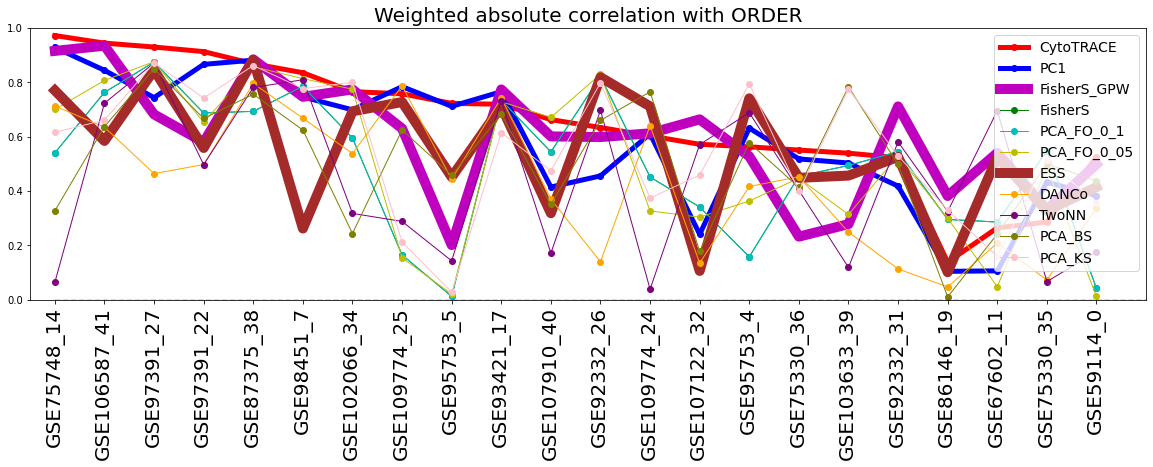

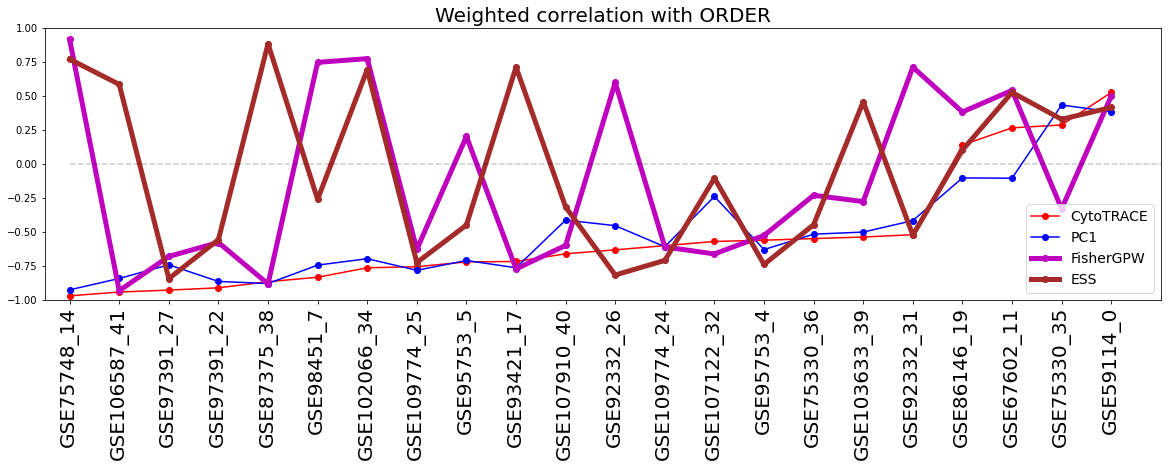

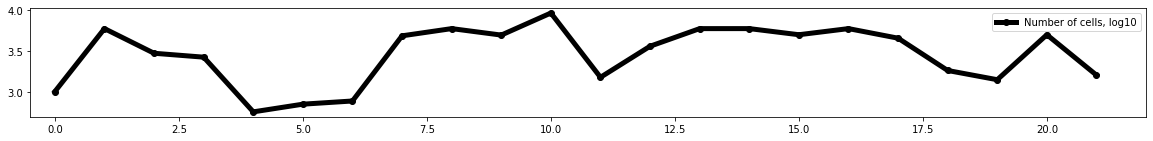

In [12]:
min_number_of_cells = 500

methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05','ESS','DANCo','TwoNN','PCA_BS','PCA_KS']
colors = ['m','g','c','y','brown','orange','purple','olive','pink']

correlations_cytotrace_order = correlations_score_order['CytoTRACE']
correlations_pc1_order = correlations_score_order['PC1']
correlations_FisherGPW_surrogate_order = correlations_surrogatescore_order['FisherS_GPW']
correlations_Fisher_local_surrogate_order = correlations_surrogatescore_order['FisherS']
correlations_PCA_FO_0_1_surrogate_order = correlations_surrogatescore_order['PCA_FO_0_1']
correlations_PCA_FO_0_05_surrogate_order = correlations_surrogatescore_order['PCA_FO_0_05']

#score_for_sorting = np.abs(np.array(correlations_cytotrace_order))-np.abs((np.array(correlations_pc1_order)))
score_for_sorting = np.array(correlations_cytotrace_order)
inds = np.argsort(score_for_sorting)

filtered_inds = []
for i in inds:
    if number_of_cells[i]>min_number_of_cells:
        filtered_inds.append(i)
inds = np.array(filtered_inds)
inds1 = inds
print('inds=',inds)

plt.figure(figsize=(20,5))
labels=np.array(datasets)[inds]
plt.plot(np.abs(np.array(correlations_cytotrace_order))[inds],'ro-',linewidth=5)
plt.plot(np.abs(np.array(correlations_pc1_order))[inds],'bo-',linewidth=5)
for i,meth in enumerate(methods):
        lw = 1
        if (meth=='ESS') | (meth=='FisherS_GPW'):
            lw = 10
        plt.plot(np.abs(np.array(correlations_surrogatescore_order[meth]))[inds],'o-',color=colors[i],linewidth=lw)
plt.plot([0,len(inds)],[0,0],'k--',alpha=0.2)
plt.xlim([-0.5,len(inds)])
plt.ylim([0,1])
plt.legend(['CytoTRACE','PC1']+methods,fontsize=14)
plt.xticks(range(0,len(inds)),labels=labels,rotation='vertical',fontsize=20)
plt.title('Weighted absolute correlation with ORDER',fontsize=20)
plt.show()

#plt.figure(figsize=(20,5))
#labels=np.array(datasets)[inds]
#plt.plot(np.abs(np.array(correlations_cytotrace_order))[inds],'ko-')
#plt.plot(np.abs(np.array(correlations_pc1_order))[inds],'bo-')
#plt.plot(np.abs(np.array(correlations_FisherGPW_surrogate_order))[inds],'ro-',linewidth=5)
#plt.plot([0,len(inds)],[0,0],'k--',alpha=0.2)
#plt.xlim([-0.5,len(inds)])
#plt.ylim([0,1])
#plt.legend(['CytoTRACE','PC1','FisherGPW','ESS'],fontsize=14)
#plt.xticks(range(0,len(inds)),labels=labels,rotation='vertical',fontsize=20)
#plt.show()


plt.figure(figsize=(20,5))
plt.plot((np.array(correlations_cytotrace_order))[inds],'ro-')
plt.plot((np.array(correlations_pc1_order))[inds],'bo-')
plt.plot((np.array(correlations_FisherGPW_surrogate_order))[inds],'mo-',linewidth=5)
plt.plot((np.array(correlations_surrogatescore_order['ESS']))[inds],'o-',color='brown',linewidth=5)
plt.plot([0,len(inds)],[0,0],'k--',alpha=0.2)
plt.xlim([-0.5,len(inds)])
plt.ylim([-1,1])
plt.legend(['CytoTRACE','PC1','FisherGPW','ESS'],fontsize=14)
plt.xticks(range(0,len(inds)),labels=labels,rotation='vertical',fontsize=20)
plt.title('Weighted correlation with ORDER',fontsize=20)
plt.show()


plt.figure(figsize=(20,2))
plt.plot(np.log10(np.array(number_of_cells))[inds],'ko-',linewidth=5)
plt.xlim([-0.5,len(inds)])
plt.legend(['Number of cells, log10'])
#plt.xticks(range(0,len(inds)),labels=labels,rotation='vertical',fontsize=20)
plt.show()

#plt.figure(figsize=(20,2))
#plt.plot(np.array(global_FisherS)[inds],'ko-',linewidth=5)
#plt.plot(np.array(global_PCA_FO_0_1)[inds],'ro-',linewidth=5)
#plt.plot(np.array(global_PCA_FO_0_05)[inds],'bo-',linewidth=5)
#plt.legend(['Global FisherS','Global PCA_FO_0_1','PCA_FO_0_05'])
#plt.xlim([-0.5,len(inds)])
#plt.xticks(range(0,len(inds)),labels=labels,rotation='vertical',fontsize=20)
#plt.show()

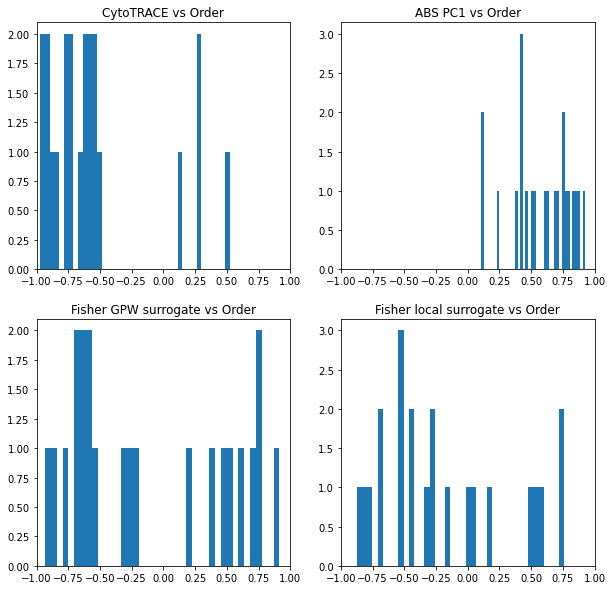

In [13]:
plt.figure(figsize=(10,10))

score_for_sorting = (np.abs(np.array(correlations_cytotrace_order))-np.abs(np.abs(np.array(correlations_pc1_order))))
inds = np.argsort(score_for_sorting)

filtered_inds = []
for i in inds:
    if number_of_cells[i]>min_number_of_cells:
        filtered_inds.append(i)
inds = np.array(filtered_inds)

plt.subplot(221)
plt.hist((np.array(correlations_cytotrace_order)[inds]),bins=40)
plt.title('CytoTRACE vs Order')
plt.xlim([-1,1])

plt.subplot(222)
plt.hist(np.abs(np.array(correlations_pc1_order)[inds]),bins=40)
plt.title('ABS PC1 vs Order')
plt.xlim([-1,1])

plt.subplot(223)
plt.hist((np.array(correlations_FisherGPW_surrogate_order)[inds]),bins=40)
plt.title('Fisher GPW surrogate vs Order')
plt.xlim([-1,1])

plt.subplot(224)
plt.hist((np.array(correlations_Fisher_local_surrogate_order)[inds]),bins=40)
plt.title('Fisher local surrogate vs Order')
plt.xlim([-1,1])


plt.show()

Failures of FisherS_GPW:
GSE95753_5 0.2009065657605179
GSE86146_19 0.38152037912315917
GSE75330_35 -0.33175946545713586
GSE75330_36 -0.23188803318078308
GSE103633_39 -0.27798876782915755
Cases when FisherS_GPW is very differnt from CytoTRACE:
GSE95753_5 FisherS_GPW= 0.2009065657605179 CytoTRACE= -0.7595732234985685
GSE67602_11 FisherS_GPW= 0.5401307121879283 CytoTRACE= 0.23900333444550753
GSE97391_22 FisherS_GPW= -0.5793252350900312 CytoTRACE= -0.880044268237439
GSE103633_39 FisherS_GPW= -0.27798876782915755 CytoTRACE= -0.5888974127919995


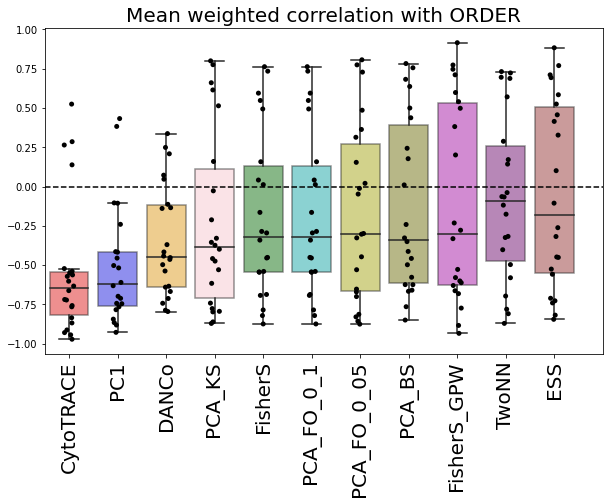

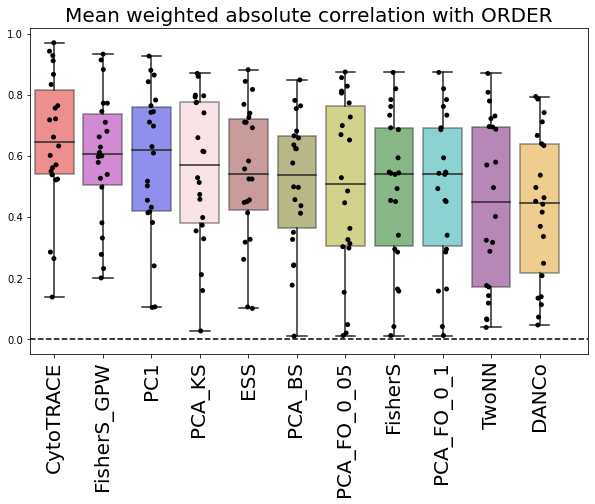

In [23]:
methods = ['FisherS_GPW','FisherS','PCA_FO_0_1','PCA_FO_0_05','ESS','DANCo','TwoNN','PCA_BS','PCA_KS']
colors = ['m','g','c','y','brown','orange','purple','olive','pink']
id_pal = {}
id_pal['CytoTRACE'] = 'r'
id_pal['PC1'] = 'b'
for i,meth in enumerate(methods):
    id_pal[meth] = colors[i]
    
min_number_of_cells = 500
inds_numcells = np.argwhere(np.array(number_of_cells)>min_number_of_cells)

data = {'ID':list(np.array(datasets)[inds_numcells]),
        'CytoTRACE':list(np.array(correlations_score_order['CytoTRACE'])[inds_numcells]),
        'PC1':list(np.array(correlations_score_order['PC1'])[inds_numcells])}
for meth in methods:
    data[meth] = list(np.array(correlations_surrogatescore_order[meth])[inds_numcells])
    
print('Failures of FisherS_GPW:')
for i in inds_numcells:
    corr = correlations_surrogatescore_order['FisherS_GPW'][i[0]]
    if abs(corr)<0.4:
        print(datasets[i[0]],corr)
        
print('Cases when FisherS_GPW is very differnt from CytoTRACE:')
for i in inds_numcells:
    corrFS = correlations_surrogatescore_order['FisherS_GPW'][i[0]]
    corrCT = correlations_surrogatescore_order['CytoTRACE'][i[0]]
    if abs(abs(corrFS)-abs(corrCT))>0.3:
        print(datasets[i[0]],'FisherS_GPW=',corrFS,'CytoTRACE=',corrCT)

    
df = pd.DataFrame(data)
cols = df.columns.tolist()
inds = np.argsort(df.mean().to_numpy())
cols_new = [cols[0]]+[cols[1+i] for i in inds]
plt.figure(figsize=(10,6))
sns.stripplot(data=df[cols_new],color='k')
plt.plot([-0.5,len(inds)],[0,0],'k--')
chart = sns.boxplot(data=df[cols_new], showfliers = False, palette=id_pal, boxprops=dict(alpha=.5))
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=20)
plt.xlim([-0.5,len(inds)])
plt.title('Mean weighted correlation with ORDER',fontsize=20)
plt.show()

data = {'ID':list(np.array(datasets)[inds_numcells]),
        'CytoTRACE':list(np.abs(np.array(correlations_score_order['CytoTRACE'])[inds_numcells])),
        'PC1':list(np.abs(np.array(correlations_score_order['PC1'])[inds_numcells]))}
for meth in methods:
    data[meth] = list(np.abs(np.array(correlations_surrogatescore_order[meth])[inds_numcells]))
    
df = pd.DataFrame(data)
cols = df.columns.tolist()
inds = np.argsort(-df.mean().to_numpy())
cols_new = [cols[0]]+[cols[1+i] for i in inds]
plt.figure(figsize=(10,6))
sns.stripplot(data=df[cols_new],color='k')
plt.plot([-0.5,len(inds)],[0,0],'k--')
chart = sns.boxplot(data=df[cols_new], showfliers = False, palette=id_pal, boxprops=dict(alpha=.5))
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=20)
plt.xlim([-0.5,len(inds)])
plt.title('Mean weighted absolute correlation with ORDER',fontsize=20)
plt.show()
